## Set up environment and set parameters

In [788]:
import os
from os.path import join as ospj
import json
import glob
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style='white')
import matplotlib.pyplot as plt
import warnings
import scipy.stats as stats
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
import statsmodels.api as sm
import bct
from bct import algorithms
import pickle

# Get current directory
code_path = os.getcwd()

# Get absolute path from config file
with open(ospj(code_path, "config.json"), "rb") as f:
    config = json.load(f)
repo_path = config["repoPath"]
ieeg_path = ospj(repo_path, "outputs", "ieeg")
fmri_path = ospj(repo_path, "outputs", "fmri_seg_masked")

# Extract window number from file name
def extract_win_x(s):
    start_index = s.find('win-') + len('win-')
    end_index = s.find('_', start_index)
    win_x_str = s[start_index:end_index]
    return int(win_x_str)    

# Convert vectorized connectivity matrix into symmetric
def vec_to_sym_matrix(vec):

    n = int(np.sqrt(2 * len(vec))) + 1  # Determine the size of the matrix
    matrix = np.zeros((n, n))  # Create an empty matrix

    tril_indices = np.tril_indices(n, k=-1)  # Get the indices of the lower triangle

    matrix[tril_indices] = vec # Fill the lower triangle of the matrix with the vectorized matrix
    matrix_sym = matrix + matrix.T # Add the transpose of the matrix to the matrix to make it symmetric

    return matrix_sym

# Set parameters
states = ['interictal', 'preictal', 'ictal']
#freq_bands = ["broadband", "delta", "theta", "alpha", "beta", "gamma"]
freq_bands = ["broadband", "alpha"]
tissue_types = ['wm','gm']
radii = [8]
fmri_conn_types = ['spearman']
ieeg_conn_types = ['spearman']
win_params = ['dyn_conn_len-60000_winlen-10000_winoverlap-7500']
graph_measures = ['global_efficiency', 'cluster_coef', 'modularity']

# Definte subjects to use
subs_list = os.listdir(ieeg_path)
subs = [item for item in subs_list if os.path.isdir(os.path.join(ieeg_path, item))]
excl_dirs = ["time_windows", "sub-RID0050", 'sub-RID0102'] #'sub-RID0420', 'sub-RID0089', 'sub-RID0658'
subs = [item for item in subs if item not in excl_dirs]

## Load iEEG dynamic connectivity data

### Extract connectivity

Takes a while - I recommend pickling these dictionaries so you only have to run once

In [789]:
print("Extracting iEEG dynamic connectivity + network measures...")

ieeg = {}
ieeg_graph = {}
for sub in subs:

    print(sub)

    ieeg[sub] = {}
    ieeg_graph[sub] = {}

    for tissue_type in tissue_types:

        ieeg[sub][tissue_type] = {}
        ieeg_graph[sub][tissue_type] = {}

        for state in states:

            ieeg[sub][tissue_type][state] = {}
            ieeg_graph[sub][tissue_type][state] = {}

            # Define seizure state directory
            state_dir = ospj(ieeg_path, sub, 'dynamic_connectivity', state)

            for band in freq_bands:

                ieeg[sub][tissue_type][state][band] = {}
                ieeg_graph[sub][tissue_type][state][band] = {}

                for ieeg_conn_type in ieeg_conn_types:

                    ieeg[sub][tissue_type][state][band][ieeg_conn_type] = {}
                    ieeg_graph[sub][tissue_type][state][band][ieeg_conn_type] = {}

                    for win_param in win_params:

                        ieeg[sub][tissue_type][state][band][ieeg_conn_type][win_param] = {}
                        ieeg_graph[sub][tissue_type][state][band][ieeg_conn_type][win_param] = {}

                        # Extract seizure IDs
                        sz_ids_list = os.listdir(state_dir)
                        sz_ids = [item for item in sz_ids_list if os.path.isdir(os.path.join(state_dir, item))]

                        for sz_id in sz_ids:

                            # Fitler files in seizure directory
                            tissue_files = [item for item in os.listdir(ospj(state_dir, sz_id, win_param)) if tissue_type in item]
                            state_files = [item for item in tissue_files if state in item]
                            band_files = [item for item in state_files if band in item]
                            ieeg_conn_files = [item for item in band_files if ieeg_conn_type in item]

                            # Check if data is missing
                            if len(ieeg_conn_files) == 0:
                                #print('Missing data: ' + sub + ' - ' + tissue_type + ' - ' + state + ' - ' + band + ' - ' + ieeg_conn_type + ' - ' + win_param + ' - ' + sz_id)
                                continue
                            else:
                                test_file = pd.read_csv(ospj(state_dir, sz_id, win_param, ieeg_conn_files[0]))
                                test_file.drop(test_file.columns[0], axis=1, inplace=True)
                                test_file_tril = test_file.values[np.tril_indices(test_file.shape[0], k=-1)]
                                if np.any(np.isnan(test_file_tril)):
                                    #print('Missing data: ' + sub + ' - ' + tissue_type + ' - ' + state + ' - ' + band + ' - ' + ieeg_conn_type + ' - ' + win_param + ' - ' + sz_id)
                                    continue

                            corrs = []
                            global_efficiencies = []
                            cluster_coefs = []
                            modularities = []
                            for file in sorted(ieeg_conn_files, key=extract_win_x):

                                # Load file
                                file_df = pd.read_csv(ospj(state_dir, sz_id, win_param, file))

                                # Remove column of labels
                                file_df.drop(file_df.columns[0], axis=1, inplace=True)
                                
                                # Vectorize ieeg connectivity, removing NANs
                                connectivity_vectorized = file_df.values.flatten()
                                connectivity_vectorized = connectivity_vectorized[~np.isnan(connectivity_vectorized)]
                                


                                # Save correlations
                                corrs.append(connectivity_vectorized)
                                
                                # Compute graph metrics
                                connectivity_sym = vec_to_sym_matrix(connectivity_vectorized)

                                #print(sub + ' - ' + tissue_type + ' - ' + state + ' - ' + band + ' - ' + ieeg_conn_type + ' - ' + win_param + ' - ' + sz_id + ' - ' + file)

                                global_efficiencies.append(algorithms.efficiency_wei(np.abs(connectivity_sym), local=False))
                                cluster_coefs.append(np.mean(algorithms.clustering_coef_wd(connectivity_sym)))
                                modularities.append(algorithms.modularity_louvain_und(np.abs(connectivity_sym), gamma=1)[1])
                            
                            # Save connectivity/graph metrics
                            ieeg[sub][tissue_type][state][band][ieeg_conn_type][win_param][sz_id] = corrs
                            ieeg_graph[sub][tissue_type][state][band][ieeg_conn_type][win_param][sz_id] = {}
                            ieeg_graph[sub][tissue_type][state][band][ieeg_conn_type][win_param][sz_id]['global_efficiency'] = global_efficiencies
                            ieeg_graph[sub][tissue_type][state][band][ieeg_conn_type][win_param][sz_id]['cluster_coef'] = cluster_coefs
                            ieeg_graph[sub][tissue_type][state][band][ieeg_conn_type][win_param][sz_id]['modularity'] = modularities                                

Extracting iEEG dynamic connectivity + network measures...
sub-RID0037
sub-RID0490
sub-RID0031
sub-RID0658
sub-RID0143
sub-RID0520
sub-RID0529
sub-RID0117
sub-RID0572
sub-RID0566
sub-RID0194
sub-RID0309
sub-RID0365
sub-RID0502
sub-RID0440
sub-RID0459
sub-RID0051
sub-RID0652
sub-RID0032
sub-RID0583
sub-RID0320
sub-RID0522
sub-RID0536
sub-RID0139
sub-RID0596
sub-RID0508
sub-RID0278
sub-RID0420
sub-RID0679
sub-RID0646
sub-RID0648
sub-RID0089


## Load fMRI connectivity data

In [790]:
fmri = {}
for sub in subs:

    fmri[sub] = {}

    for tissue_type in tissue_types:

        fmri[sub][tissue_type] = {}

        for radius in radii:

            fmri[sub][tissue_type][radius] = {}

            for fmri_conn_type in fmri_conn_types:

                fmri[sub][tissue_type][radius][fmri_conn_type] = {}

                file = pd.read_csv(ospj(fmri_path, sub, "connectivity", sub + "_" + tissue_type + "_fmri_connectivity-" + fmri_conn_type + "_radius-" + str(radius) + "mm.csv"))

                # Extract electrode labels
                labels = file.iloc[:,0]

                # Remove column of labels
                file.drop(file.columns[0], axis=1, inplace=True)

                # Vectorize ieeg connectivity
                connectivity_vectorized = file.values.flatten()
                connectivity_vectorized = connectivity_vectorized[~np.isnan(connectivity_vectorized)]

                fmri[sub][tissue_type][radius][fmri_conn_type] = connectivity_vectorized

## Compute dynamic iEEG-fMRI measures

### Compute dynamic iEEG-fMRI correlations

#### Seizure-level

In [791]:
# Compute dynamic iEEG-fMRI correlations at the seizure level
ieeg_fmri_corrs_sz = {}
for sub in fmri.keys():

    print(sub)

    ieeg_fmri_corrs_sz[sub] = {}
    for tissue_type in fmri[sub].keys():
    
        ieeg_fmri_corrs_sz[sub][tissue_type] = {}
        for radius in fmri[sub][tissue_type].keys():

            ieeg_fmri_corrs_sz[sub][tissue_type][radius] = {}
            for fmri_conn_type in fmri[sub][tissue_type][radius].keys():

                # Extract fMRI connectivity
                fmri_conn = fmri[sub][tissue_type][radius][fmri_conn_type]

                ieeg_fmri_corrs_sz[sub][tissue_type][radius][fmri_conn_type] = {}
                for state in ieeg[sub][tissue_type].keys():

                    ieeg_fmri_corrs_sz[sub][tissue_type][radius][fmri_conn_type][state] = {}
                    for band in ieeg[sub][tissue_type][state].keys():

                        ieeg_fmri_corrs_sz[sub][tissue_type][radius][fmri_conn_type][state][band] = {}
                        for ieeg_conn_type in ieeg[sub][tissue_type][state][band].keys():

                            ieeg_fmri_corrs_sz[sub][tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type] = {}
                            for win_param in ieeg[sub][tissue_type][state][band][ieeg_conn_type].keys():

                                ieeg_fmri_corrs_sz[sub][tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type][win_param] = {}
                                for sz_id in ieeg[sub][tissue_type][state][band][ieeg_conn_type][win_param].keys():

                                    ieeg_fmri_corrs_sz[sub][tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type][win_param][sz_id] = {}
                                    for window in range(np.shape(ieeg[sub][tissue_type][state][band][ieeg_conn_type][win_param][sz_id])[0]):

                                        # Extract iEEG connectivity for window
                                        ieeg_conn = ieeg[sub][tissue_type][state][band][ieeg_conn_type][win_param][sz_id][window]

                                        # Save correlation
                                        ieeg_fmri_corrs_sz[sub][tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type][win_param][sz_id][window] = np.corrcoef(ieeg_conn, fmri_conn)[0,1]


sub-RID0037
sub-RID0490
sub-RID0031
sub-RID0658
sub-RID0143
sub-RID0520
sub-RID0529
sub-RID0117
sub-RID0572
sub-RID0566
sub-RID0194
sub-RID0309
sub-RID0365
sub-RID0502
sub-RID0440
sub-RID0459
sub-RID0051
sub-RID0652
sub-RID0032
sub-RID0583
sub-RID0320
sub-RID0522
sub-RID0536
sub-RID0139
sub-RID0596
sub-RID0508
sub-RID0278
sub-RID0420
sub-RID0679
sub-RID0646
sub-RID0648
sub-RID0089


#### Subject-level

In [803]:
# Compute dynamic iEEG-fMRI correlations at the seizure level
ieeg_fmri_corrs_sub = {}
ieeg_fmri_corrs_sz = {}
for sub in fmri.keys():

    print(sub)

    ieeg_fmri_corrs_sub[sub] = {}
    ieeg_fmri_corrs_sz[sub] = {}
    for tissue_type in fmri[sub].keys():
    
        ieeg_fmri_corrs_sub[sub][tissue_type] = {}
        ieeg_fmri_corrs_sz[sub][tissue_type] = {}
        for radius in fmri[sub][tissue_type].keys():

            ieeg_fmri_corrs_sub[sub][tissue_type][radius] = {}
            ieeg_fmri_corrs_sz[sub][tissue_type][radius] = {}
            for fmri_conn_type in fmri[sub][tissue_type][radius].keys():

                # Extract fMRI connectivity
                fmri_conn = fmri[sub][tissue_type][radius][fmri_conn_type]

                ieeg_fmri_corrs_sub[sub][tissue_type][radius][fmri_conn_type] = {}
                ieeg_fmri_corrs_sz[sub][tissue_type][radius][fmri_conn_type] = {}
                for state in ieeg[sub][tissue_type].keys():

                    ieeg_fmri_corrs_sub[sub][tissue_type][radius][fmri_conn_type][state] = {}
                    ieeg_fmri_corrs_sz[sub][tissue_type][radius][fmri_conn_type][state] = {}
                    for band in ieeg[sub][tissue_type][state].keys():

                        ieeg_fmri_corrs_sub[sub][tissue_type][radius][fmri_conn_type][state][band] = {}
                        ieeg_fmri_corrs_sz[sub][tissue_type][radius][fmri_conn_type][state][band] = {}
                        for ieeg_conn_type in ieeg[sub][tissue_type][state][band].keys():

                            ieeg_fmri_corrs_sub[sub][tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type] = {}
                            ieeg_fmri_corrs_sz[sub][tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type] = {}
                            for win_param in ieeg[sub][tissue_type][state][band][ieeg_conn_type].keys():

                                ieeg_fmri_corrs_avg = []
                                for sz_id in ieeg[sub][tissue_type][state][band][ieeg_conn_type][win_param].keys():

                                    ieeg_fmri_corrs_avg_sz = []
                                    for window in range(np.shape(ieeg[sub][tissue_type][state][band][ieeg_conn_type][win_param][sz_id])[0]):

                                        # Extract iEEG connectivity for window
                                        ieeg_conn = ieeg[sub][tissue_type][state][band][ieeg_conn_type][win_param][sz_id][window]

                                        # Save correlation
                                        ieeg_fmri_corrs_avg_sz.append(np.corrcoef(ieeg_conn, fmri_conn)[0,1])

                                    ieeg_fmri_corrs_sz[sub][tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type][sz_id] = ieeg_fmri_corrs_avg_sz
                                    ieeg_fmri_corrs_avg.append(ieeg_fmri_corrs_avg_sz)

# Save the data                 # Save average dynamic correlations across seizures, within subject
                                ieeg_fmri_corrs_sub[sub][tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type][win_param] = np.mean(np.array(ieeg_fmri_corrs_avg), axis=0)

sub-RID0037
sub-RID0490
sub-RID0031
sub-RID0658
sub-RID0143
sub-RID0520
sub-RID0529
sub-RID0117
sub-RID0572
sub-RID0566
sub-RID0194
sub-RID0309
sub-RID0365
sub-RID0502
sub-RID0440
sub-RID0459
sub-RID0051
sub-RID0652
sub-RID0032
sub-RID0583
sub-RID0320
sub-RID0522
sub-RID0536
sub-RID0139
sub-RID0596
sub-RID0508
sub-RID0278
sub-RID0420
sub-RID0679
sub-RID0646
sub-RID0648
sub-RID0089


/Users/mjaskir/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mjaskir/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Compute dynamic iEEG graph measures (seizure-level)

In [793]:
single_freq_band = 'none' # Make variable 'none' to plot all frequency bands
graph_measures = ['global_efficiency', 'modularity'] # 'cluster_coef', 'global_efficiency', 'modularity'

ieeg_graph_measures = {}
ieeg_graph_mean = {}
ieeg_graph_sd = {}

for graph_measure in graph_measures:

    ieeg_graph_measures[graph_measure]= {}
    ieeg_graph_mean[graph_measure] = {}
    ieeg_graph_sd[graph_measure] = {}
    for tissue_type in tissue_types:
        
        ieeg_graph_measures[graph_measure][tissue_type] = {}
        ieeg_graph_mean[graph_measure][tissue_type] = {}
        ieeg_graph_sd[graph_measure][tissue_type] = {}
        for state in states:  

            ieeg_graph_measures[graph_measure][tissue_type][state] = {}
            ieeg_graph_mean[graph_measure][tissue_type][state] = {}
            ieeg_graph_sd[graph_measure][tissue_type][state] = {}
            for band in freq_bands:
            
                if single_freq_band != 'none':
                    if band != single_freq_band:
                        continue
                
                ieeg_graph_measures[graph_measure][tissue_type][state][band] = {}
                ieeg_graph_mean[graph_measure][tissue_type][state][band] = {}
                ieeg_graph_sd[graph_measure][tissue_type][state][band] = {}
                for ieeg_conn_type in ieeg_conn_types:

                    ieeg_graph_measures[graph_measure][tissue_type][state][band][ieeg_conn_type] = {}
                    ieeg_graph_mean[graph_measure][tissue_type][state][band][ieeg_conn_type] = {}
                    ieeg_graph_sd[graph_measure][tissue_type][state][band][ieeg_conn_type] = {}
                    for win_param in win_params:

                        ieeg_graph_measures[graph_measure][tissue_type][state][band][ieeg_conn_type][win_param] = {}
                        ieeg_graph_mean[graph_measure][tissue_type][state][band][ieeg_conn_type][win_param] = {}
                        ieeg_graph_sd[graph_measure][tissue_type][state][band][ieeg_conn_type][win_param] = {}
                        dyn_conn_avg = []
                        for sub in subs:

                            for sz_id in ieeg_graph[sub][tissue_type][state][band][ieeg_conn_type][win_param].keys():

                                dyn_conn_sz = []
                                for window in range(np.shape(ieeg_graph[sub][tissue_type][state][band][ieeg_conn_type][win_param][sz_id][graph_measure])[0]):

                                    dyn_conn_window = ieeg_graph[sub][tissue_type][state][band][ieeg_conn_type][win_param][sz_id][graph_measure][window]
                                    dyn_conn_sz.append(dyn_conn_window)

                                # Skip missing data
                                if np.shape(dyn_conn_sz)[0] == 0:
                                    continue
                                
                                dyn_conn_avg.append(dyn_conn_sz)

                        ieeg_graph_measures[graph_measure][tissue_type][state][band][ieeg_conn_type][win_param] = dyn_conn_avg
                        ieeg_graph_mean[graph_measure][tissue_type][state][band][ieeg_conn_type][win_param] = np.mean(dyn_conn_avg, axis=0)
                        ieeg_graph_sd[graph_measure][tissue_type][state][band][ieeg_conn_type][win_param] = np.std(dyn_conn_avg, axis=0)



### Compute dynamic iEEG graph measures (subject-level)

In [794]:
single_freq_band = 'none' # Make variable 'none' to plot all frequency bands
graph_measures = ['global_efficiency', 'modularity'] # 'cluster_coef', 'global_efficiency', 'modularity'

# Load data into dictionary
ieeg_graph_measures_sub = {}
ieeg_graph_mean_sub = {}
ieeg_graph_sd_sub = {}

for graph_measure in graph_measures:

    ieeg_graph_measures_sub[graph_measure]= {}
    ieeg_graph_mean_sub[graph_measure] = {}
    ieeg_graph_sd_sub[graph_measure] = {}
    for tissue_type in tissue_types:
        
        ieeg_graph_measures_sub[graph_measure][tissue_type] = {}
        ieeg_graph_mean_sub[graph_measure][tissue_type] = {}
        ieeg_graph_sd_sub[graph_measure][tissue_type] = {}
        for state in states:  

            ieeg_graph_measures_sub[graph_measure][tissue_type][state] = {}
            ieeg_graph_mean_sub[graph_measure][tissue_type][state] = {}
            ieeg_graph_sd_sub[graph_measure][tissue_type][state] = {}
            for band in freq_bands:
            
                if single_freq_band != 'none':
                    if band != single_freq_band:
                        continue
                
                ieeg_graph_measures_sub[graph_measure][tissue_type][state][band] = {}
                ieeg_graph_mean_sub[graph_measure][tissue_type][state][band] = {}
                ieeg_graph_sd_sub[graph_measure][tissue_type][state][band] = {}
                for ieeg_conn_type in ieeg_conn_types:

                    ieeg_graph_measures_sub[graph_measure][tissue_type][state][band][ieeg_conn_type] = {}
                    ieeg_graph_mean_sub[graph_measure][tissue_type][state][band][ieeg_conn_type] = {}
                    ieeg_graph_sd_sub[graph_measure][tissue_type][state][band][ieeg_conn_type] = {}
                    for win_param in win_params:

                        ieeg_graph_measures_sub[graph_measure][tissue_type][state][band][ieeg_conn_type][win_param] = {}
                        ieeg_graph_mean_sub[graph_measure][tissue_type][state][band][ieeg_conn_type][win_param] = {}
                        ieeg_graph_sd_sub[graph_measure][tissue_type][state][band][ieeg_conn_type][win_param] = {}

                        dyn_conn_avg = []
                        for sub in subs:

                            dyn_conn_sub = []
                            for sz_id in ieeg_graph[sub][tissue_type][state][band][ieeg_conn_type][win_param].keys():

                                dyn_conn_sz = []
                                for window in range(np.shape(ieeg_graph[sub][tissue_type][state][band][ieeg_conn_type][win_param][sz_id][graph_measure])[0]):

                                    dyn_conn_window = ieeg_graph[sub][tissue_type][state][band][ieeg_conn_type][win_param][sz_id][graph_measure][window]
                                    dyn_conn_sz.append(dyn_conn_window)

                                # Skip missing data
                                if np.shape(dyn_conn_sz)[0] == 0:
                                    continue
                                    
                                dyn_conn_sub.append(dyn_conn_sz)

                            ieeg_graph_measures_sub[graph_measure][tissue_type][state][band][ieeg_conn_type][win_param][sub] = dyn_conn_sub

                            # Average within-subject
                            dyn_conn_avg.append(np.mean(np.array(dyn_conn_sub), axis=0))


                        dyn_conn_avg = np.array(dyn_conn_avg)

                        # Remove subjects with NANs
                        remove_subs = []
                        for i in range(np.shape(dyn_conn_avg)[0]):
                            if np.isnan(dyn_conn_avg[i]).any():
                                remove_subs.append(i)
                        dyn_conn_avg = np.delete(dyn_conn_avg, remove_subs, axis=0)


                        ieeg_graph_mean_sub[graph_measure][tissue_type][state][band][ieeg_conn_type][win_param] = np.mean(dyn_conn_avg, axis=0)
                        ieeg_graph_sd_sub[graph_measure][tissue_type][state][band][ieeg_conn_type][win_param] = np.std(dyn_conn_avg, axis=0)

/var/folders/ly/6bsy01rd35zd6gbb3r9t4y3h0000gp/T/ipykernel_92481/1776513952.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dyn_conn_avg = np.array(dyn_conn_avg)


## Plot iEEG graph measures over time

### Seizure-level

Tissue type: gm
Frequency band: broadband
iEEG connectivity type: spearman
Window parameters: dyn_conn_len-60000_winlen-10000_winoverlap-7500
Graph measure: global_efficiency


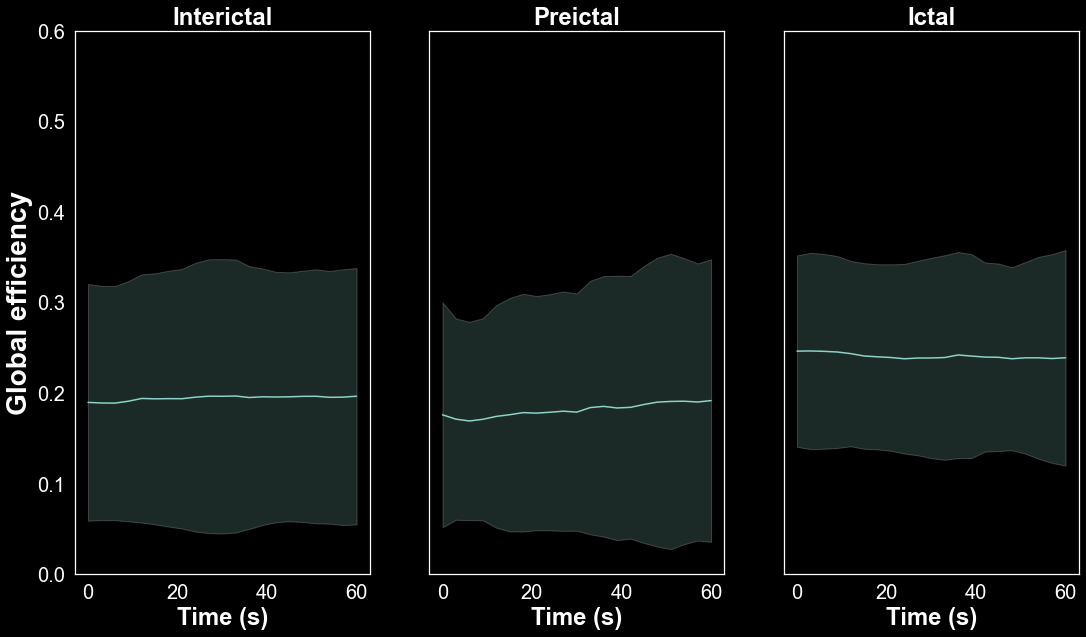

Tissue type: gm
Frequency band: broadband
iEEG connectivity type: spearman
Window parameters: dyn_conn_len-60000_winlen-10000_winoverlap-7500
Graph measure: modularity


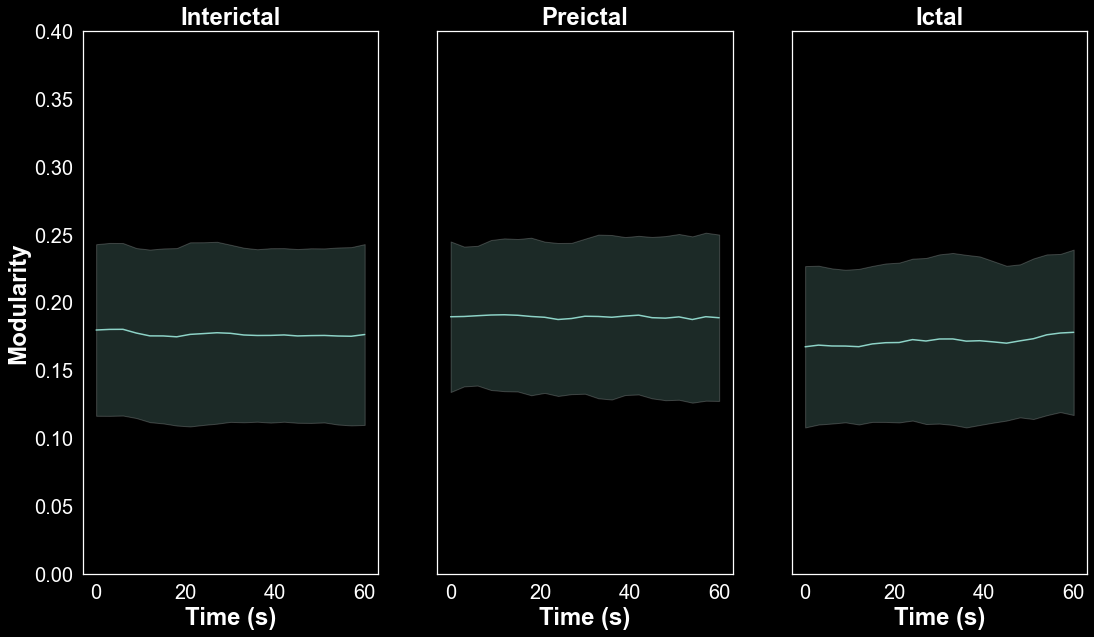

In [795]:
plt.style.use('dark_background')

for graph_measure in graph_measures:

    #for tissue_type in tissue_types:
    for tissue_type in ['gm']:

        #for band in freq_bands:
        for band in ['broadband']:

            for ieeg_conn_type in ieeg_conn_types:

                for win_param in win_params:

                    print('==========================================================')
                    print('Tissue type: ' + str(tissue_type))
                    print('Frequency band: ' + str(band))
                    print('iEEG connectivity type: ' + str(ieeg_conn_type))
                    print('Window parameters: ' + str(win_param))
                    print('Graph measure: ' + str(graph_measure))
                    print('==========================================================')

                    # Define the subplot parameters
                    num_rows = 1
                    num_cols = len(states)
                    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 10))
                    
                    for i, state in enumerate(states):

                        # Select the subplot
                        ax = axes[i]
                        
                        # Plot iEEG-fMRI correlations over time
                        mean = ieeg_graph_mean[graph_measure][tissue_type][state][band][ieeg_conn_type][win_param]
                        sd = ieeg_graph_sd[graph_measure][tissue_type][state][band][ieeg_conn_type][win_param]
                        t = np.linspace(0,60,len(mean))
                        ax.plot(t, mean)
                        ax.fill_between(t, mean - sd, mean + sd, alpha=0.2)
                        
                        if graph_measure == 'global_efficiency':
                            ax.set_ylim(0,0.6)
                        elif graph_measure == 'cluster_coef':
                            ax.set_ylim(-0.1,0.4)
                        elif graph_measure == 'modularity':
                            ax.set_ylim(0,0.4)

                        # Only include y labels/ticks on leftmost plots
                        if i == 0:
                            if graph_measure == 'global_efficiency':
                                ax.set_ylabel('Global efficiency', fontsize=28, weight='bold')
                            elif graph_measure == 'cluster_coef':
                                ax.set_ylabel('Average clustering coefficient', fontsize=24, weight='bold')
                            elif graph_measure == 'modularity':
                                ax.set_ylabel('Modularity', fontsize=24, weight='bold')
                        else:
                            ax.set_yticks([])
                            ax.set_yticklabels([])
                            
                        ax.tick_params(axis='y', which='major', labelsize=20)
                        ax.tick_params(axis='x', which='major', labelsize=20)
                        
                        ax.set_title(state.capitalize(), fontsize=24, weight='bold')
                        ax.set_xlabel('Time (s)', fontsize=24, weight='bold')

                    plt.show()

### Subject-level

Tissue type: wm
Frequency band: broadband
iEEG connectivity type: spearman
Window parameters: dyn_conn_len-60000_winlen-10000_winoverlap-7500
Graph measure: global_efficiency


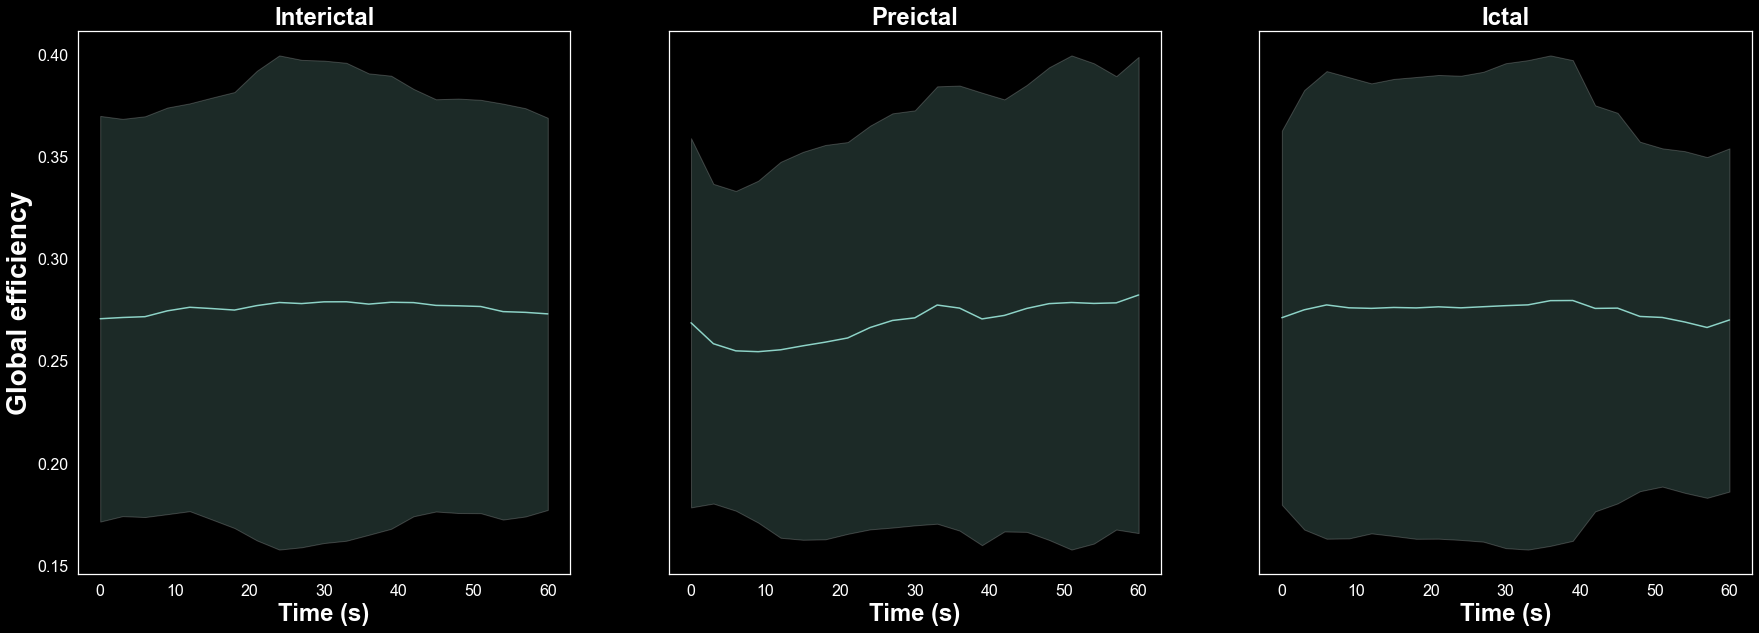

Tissue type: wm
Frequency band: broadband
iEEG connectivity type: spearman
Window parameters: dyn_conn_len-60000_winlen-10000_winoverlap-7500
Graph measure: modularity


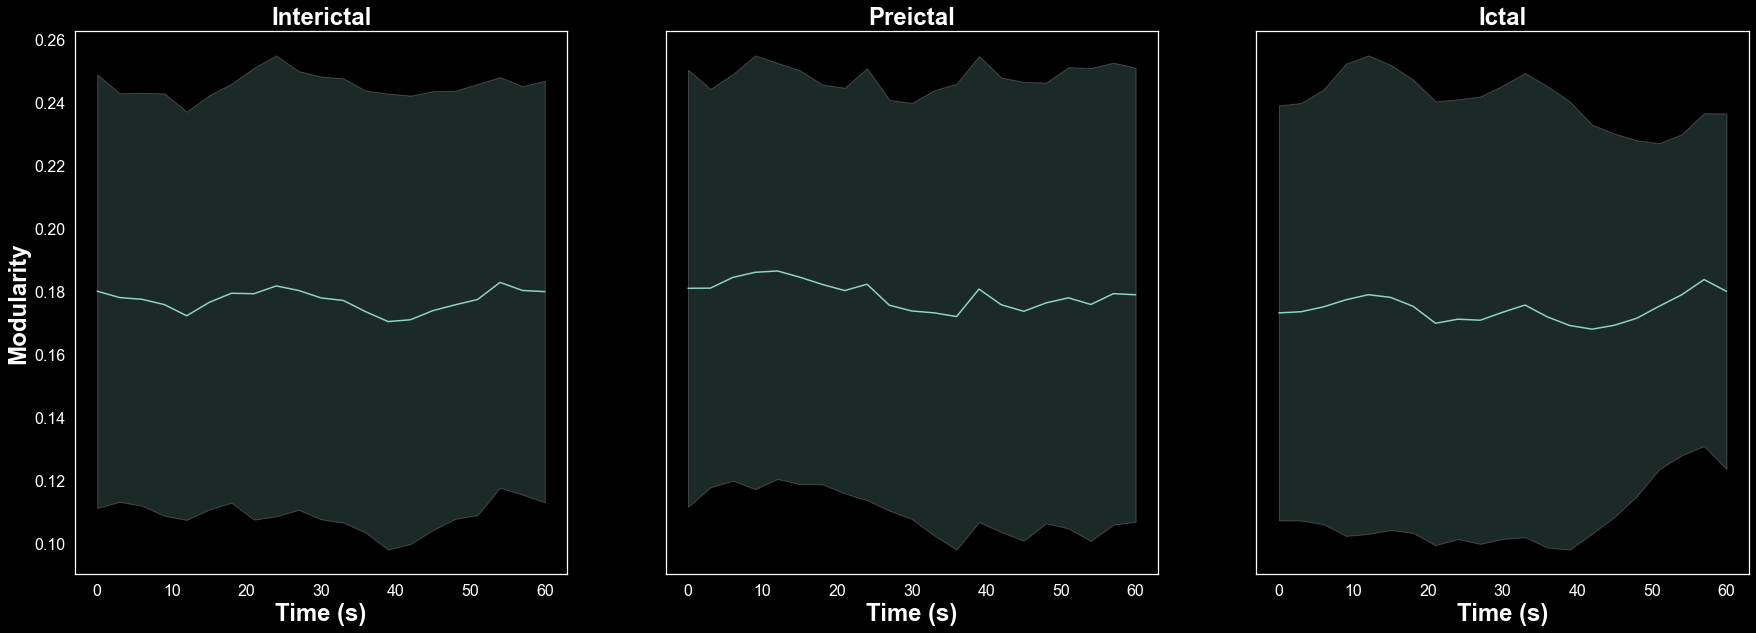

In [796]:
plt.style.use('dark_background')

for graph_measure in graph_measures:

    #for tissue_type in tissue_types:
    for tissue_type in ['wm']:

        #for band in freq_bands:
        for band in ['broadband']:

            for ieeg_conn_type in ieeg_conn_types:

                for win_param in win_params:

                    print('==========================================================')
                    print('Tissue type: ' + str(tissue_type))
                    print('Frequency band: ' + str(band))
                    print('iEEG connectivity type: ' + str(ieeg_conn_type))
                    print('Window parameters: ' + str(win_param))
                    print('Graph measure: ' + str(graph_measure))
                    print('==========================================================')

                    # Define the subplot parameters
                    num_rows = 1
                    num_cols = len(states)
                    fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 10))
                    
                    for i, state in enumerate(states):

                        # Select the subplot
                        ax = axes[i]
                        
                        # Plot iEEG-fMRI correlations over time
                        mean = ieeg_graph_mean_sub[graph_measure][tissue_type][state][band][ieeg_conn_type][win_param]
                        sd = ieeg_graph_sd_sub[graph_measure][tissue_type][state][band][ieeg_conn_type][win_param]
                        t = np.linspace(0,60,len(mean))
                        ax.plot(t, mean)
                        ax.fill_between(t, mean - sd, mean + sd, alpha=0.2)
                        
                        #if graph_measure == 'global_efficiency':
                        #    ax.set_ylim(0,0.6)
                        #elif graph_measure == 'cluster_coef':
                        #    ax.set_ylim(-0.1,0.4)
                        #elif graph_measure == 'modularity':
                        #    ax.set_ylim(0,0.4)

                        # Only include y labels/ticks on leftmost plots
                        if i == 0:
                            if graph_measure == 'global_efficiency':
                                ax.set_ylabel('Global efficiency', fontsize=28, weight='bold')
                            elif graph_measure == 'cluster_coef':
                                ax.set_ylabel('Average clustering coefficient', fontsize=24, weight='bold')
                            elif graph_measure == 'modularity':
                                ax.set_ylabel('Modularity', fontsize=24, weight='bold')
                        else:
                            ax.set_yticks([])
                            ax.set_yticklabels([])
                            
                        ax.tick_params(axis='y', which='major', labelsize=16)
                        ax.tick_params(axis='x', which='major', labelsize=16)
                        
                        ax.set_title(state.capitalize(), fontsize=24, weight='bold')
                        ax.set_xlabel('Time (s)', fontsize=24, weight='bold')

                    plt.show()

## Visualize average iEEG-fMRI correlations over time (across all seizures)

Tissue type: wm
Spherical ROI radius: 8
fMRI connectivity type: spearman
Frequency band: broadband
iEEG connectivity type: spearman
Window parameters: dyn_conn_len-60000_winlen-10000_winoverlap-7500


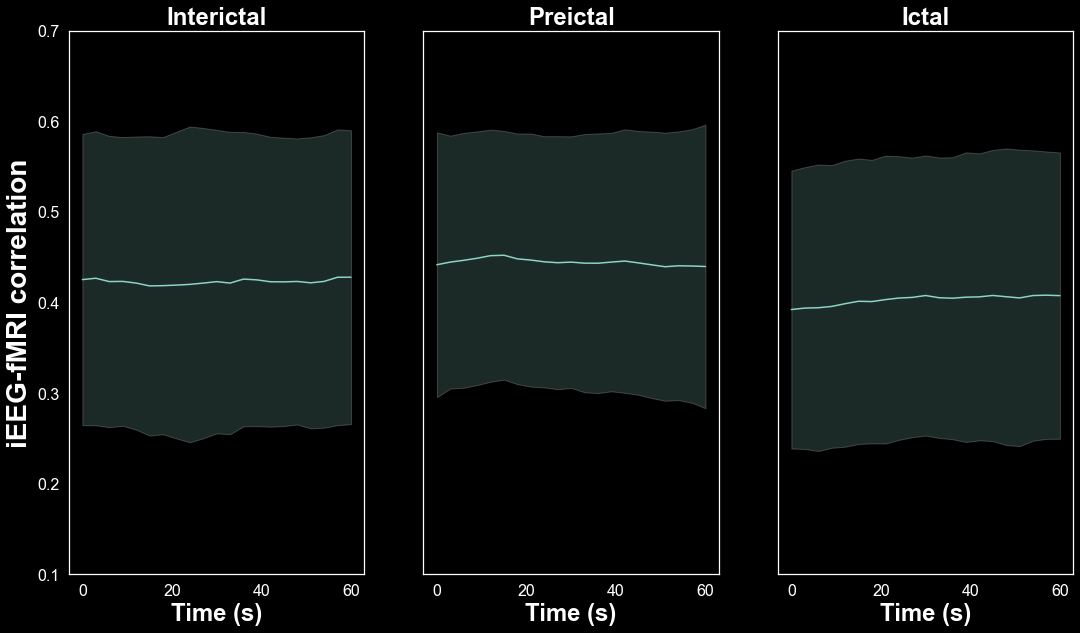

In [797]:
# ieeg_fmri_corrs_sz[sub][tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type][win_param][sz_id]

single_freq_band = 'none' # Make variable 'none' to plot all frequency bands

# Load data into dictionary
ieeg_fmri_corrs = {}
ieeg_fmri_corrs_mean = {}
ieeg_fmri_corrs_sd = {}

# Compute mean and standard deviation of dynamic iEEG-fMRI correlations across seizures for each combination of parameters
for tissue_type in tissue_types:

    ieeg_fmri_corrs[tissue_type] = {}
    ieeg_fmri_corrs_mean[tissue_type] = {}
    ieeg_fmri_corrs_sd[tissue_type] = {}
    for radius in radii:

        ieeg_fmri_corrs[tissue_type][radius] = {}
        ieeg_fmri_corrs_mean[tissue_type][radius] = {}
        ieeg_fmri_corrs_sd[tissue_type][radius] = {}
        for fmri_conn_type in fmri_conn_types:

            ieeg_fmri_corrs[tissue_type][radius][fmri_conn_type] = {}
            ieeg_fmri_corrs_mean[tissue_type][radius][fmri_conn_type] = {}
            ieeg_fmri_corrs_sd[tissue_type][radius][fmri_conn_type] = {}
            for state in states:

                ieeg_fmri_corrs[tissue_type][radius][fmri_conn_type][state] = {}
                ieeg_fmri_corrs_mean[tissue_type][radius][fmri_conn_type][state] = {}
                ieeg_fmri_corrs_sd[tissue_type][radius][fmri_conn_type][state] = {}
                for band in freq_bands:

                    if single_freq_band != 'none':
                        if band != single_freq_band:
                            continue

                    ieeg_fmri_corrs[tissue_type][radius][fmri_conn_type][state][band] = {}
                    ieeg_fmri_corrs_mean[tissue_type][radius][fmri_conn_type][state][band] = {}
                    ieeg_fmri_corrs_sd[tissue_type][radius][fmri_conn_type][state][band] = {}
                    for ieeg_conn_type in ieeg_conn_types:

                        ieeg_fmri_corrs[tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type] = {}
                        ieeg_fmri_corrs_mean[tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type] = {}
                        ieeg_fmri_corrs_sd[tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type] = {}
                        for win_param in win_params:

                            # Extract dynamic iEEG-fMRI correlations for each seizure (across subjects)
                            ieeg_fmri_corrs_dyn = []
                            for sub in subs:

                                for sz_id in ieeg_fmri_corrs_sz[sub][tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type][win_param].keys():

                                    # Extract dynamic iEEG-fMRI correlations for each seizure  
                                    ieeg_fmri_corrs_dyn_sz = []                       
                                    for window in ieeg_fmri_corrs_sz[sub][tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type][win_param][sz_id].keys():
                                            
                                        ieeg_fmri_corrs_dyn_sz.append(ieeg_fmri_corrs_sz[sub][tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type][win_param][sz_id][window])

                                    ieeg_fmri_corrs_dyn.append(ieeg_fmri_corrs_dyn_sz)

                            # Compute mean and standard deviation of dynamic iEEG-fMRI correlations across seizures
                            ieeg_fmri_corrs[tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type][win_param] = ieeg_fmri_corrs_dyn
                            ieeg_fmri_corrs_mean[tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type][win_param] = np.mean(ieeg_fmri_corrs_dyn, axis=0)
                            ieeg_fmri_corrs_sd[tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type][win_param] = np.std(ieeg_fmri_corrs_dyn, axis=0)
                                    
# Plot dynamic iEEG-fMRI correlations over time for each combination of parameters
#for tissue_type in tissue_types:
for tissue_type in ['wm']:

    for radius in radii:

        for fmri_conn_type in fmri_conn_types:
    
            #for band in freq_bands:
            for band in ['broadband']:

                if single_freq_band != 'none':
                    if band != single_freq_band:
                        continue

                for ieeg_conn_type in ieeg_conn_types:

                    for win_param in win_params:

                        print('==========================================================')
                        print('Tissue type: ' + str(tissue_type))
                        print('Spherical ROI radius: ' + str(radius))
                        print('fMRI connectivity type: ' + str(fmri_conn_type))
                        print('Frequency band: ' + str(band))
                        print('iEEG connectivity type: ' + str(ieeg_conn_type))
                        print('Window parameters: ' + str(win_param))
                        print('==========================================================')

                        # Define the subplot parameters
                        num_rows = 1
                        num_cols = len(states)
                        fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 10))
                        
                        for i, state in enumerate(states):

                            # Select the subplot
                            ax = axes[i]
                            
                            # Plot iEEG-fMRI correlations over time
                            mean = ieeg_fmri_corrs_mean[tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type][win_param]
                            sd = ieeg_fmri_corrs_sd[tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type][win_param]
                            t = np.linspace(0,60,len(mean))
                            ax.plot(t, mean)
                            ax.fill_between(t, mean - sd, mean + sd, alpha=0.2)

                            # Only include y labels/ticks on leftmost plots
                            if i == 0:
                                ax.set_ylabel('iEEG-fMRI correlation', fontsize=28, weight='bold')
                            else:
                                ax.set_yticks([])
                                ax.set_yticklabels([])
                                
                            ax.tick_params(axis='y', which='major', labelsize=16)
                            ax.tick_params(axis='x', which='major', labelsize=16)
                            
                            ax.set_title(state.capitalize(), fontsize=24, weight='bold')
                            ax.set_xlabel('Time (s)', fontsize=24, weight='bold')

                            ax.set_ylim(0.1,0.7)

                        plt.show()


### Compare interictal, preictal, ictal (first 10s and last 10s) global efficiency

t = 3.6814990703462915
p = 0.0002723212874872659


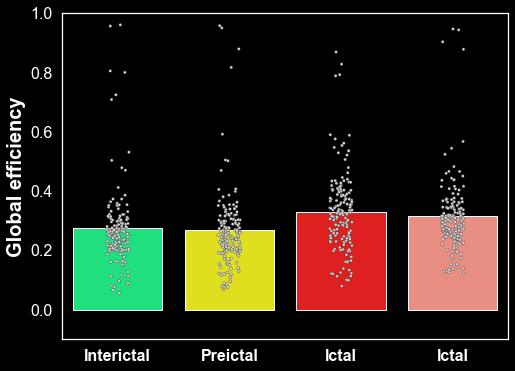

In [798]:
# ieeg_graph_corrs[tissue_type][state][band][ieeg_conn_type][win_param]

tissue_type = 'wm'
band = 'broadband'
ieeg_conn_type = 'spearman'
win_param = 'dyn_conn_len-60000_winlen-10000_winoverlap-7500'


# Create data frame
ieeg_graph_comparison = pd.DataFrame(columns=['interictal', 'preictal', 'ictal_first_10s', 'ictal_last_10s'])

for state in states:

    ieeg_graph_state = ieeg_graph_measures['global_efficiency'][tissue_type][state][band][ieeg_conn_type][win_param]

    if state in ["interictal", "preictal"]:

        # Average ieeg_fmri_corrs_state across columns
        ieeg_graph_state_avg = np.mean(ieeg_graph_state, axis=1)

        # Trim so number of samples is the same for each state
        if state == "preictal":
            ieeg_graph_state_avg = ieeg_graph_state_avg[1:len(ieeg_graph_state_avg)]

        # Add to dataframe
        ieeg_graph_comparison[state] = ieeg_graph_state_avg

    elif state == "ictal":

        # Extract only first column of ieeg_fmri_corrs_state
        ieeg_graph_state_first_10s = np.array(ieeg_graph_state)[:,0]
        ieeg_graph_state_last_10s = np.array(ieeg_graph_state)[:,-1]

        # Trim so number of samples is the same for each state
        ieeg_graph_state_first_10s = ieeg_graph_state_first_10s[1:len(ieeg_graph_state_first_10s)]
        ieeg_graph_state_last_10s = ieeg_graph_state_last_10s[1:len(ieeg_graph_state_last_10s)]

        # Add to dataframe
        ieeg_graph_comparison['ictal_first_10s'] = ieeg_graph_state_first_10s
        ieeg_graph_comparison['ictal_last_10s'] = ieeg_graph_state_last_10s

# Convert ieeg_graph_comparison to long format
ieeg_graph_comparison = ieeg_graph_comparison.reset_index().melt(id_vars='index')
ieeg_graph_comparison = ieeg_graph_comparison.drop(columns=['index'])
ieeg_graph_comparison.rename(columns={'variable': 'state', 'value': 'global_efficiency'}, inplace=True)

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='state', y='global_efficiency', data=ieeg_graph_comparison, palette=['springgreen', 'yellow', 'red', 'salmon'], ci=None)
sns.stripplot(x='state', y='global_efficiency', data=ieeg_graph_comparison, palette=['lightgrey','lightgrey','lightgrey','lightgrey','lightgrey','lightgrey'], jitter=True, dodge=True, s=3, edgecolor='black', linewidth=0.25)

# Set the title and axis labels
plt.xticks(fontsize=16, weight='bold')
plt.yticks(fontsize=16)
plt.xlabel('', fontsize=20, weight='bold')
plt.ylabel('Global efficiency', fontsize=20, weight='bold')
plt.ylim([-0.1,1])
plt.title('', fontsize=16, weight='bold')

# Rename x-axis labels
plt.xticks([0,1,2,3], ['Interictal', 'Preictal', 'Ictal', 'Ictal'])
# Show the plot
plt.show()

### Compare interictal, preictal, ictal (first 10s and last 10s) iEEG-fMRI correlations

interictal
preictal
ictal


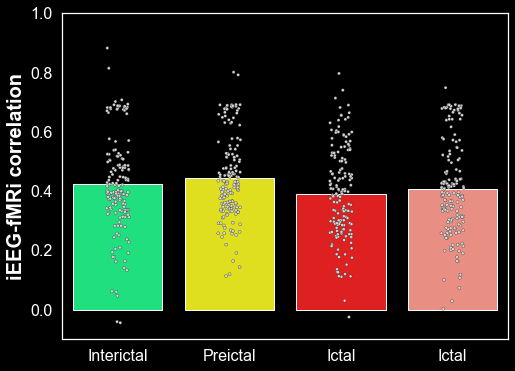

In [675]:
tissue_type = 'wm'
radius = 8
fmri_conn_type = 'spearman'
band = 'broadband'
ieeg_conn_type = 'spearman'
win_param = 'dyn_conn_len-60000_winlen-10000_winoverlap-7500'

# Create a dataframe called 'ieeg_fmri_ictal_comparison' with 4 columns: 'interictal_corrs', 'preictal_corrs', 'ictal_first_10s_corrs', 'ictal_last_10s_corrs'
ieeg_fmri_ictal_comparison = pd.DataFrame(columns=['interictal_corrs', 'preictal_corrs', 'ictal_first_10s_corrs', 'ictal_last_10s_corrs'])

for state in states:

    ieeg_fmri_corrs_state = ieeg_fmri_corrs[tissue_type][radius][fmri_conn_type][state][band][ieeg_conn_type][win_param]

    print(state)

    if state in ["interictal", "preictal"]:

        # Average ieeg_fmri_corrs_state across columns
        ieeg_fmri_corrs_state_avg = np.mean(ieeg_fmri_corrs_state, axis=1)

        # Trim so number of samples is the same for each state
        if state == "preictal":
            ieeg_fmri_corrs_state_avg = ieeg_fmri_corrs_state_avg[1:len(ieeg_fmri_corrs_state_avg)]

        # Add to dataframe
        ieeg_fmri_ictal_comparison[state + '_corrs'] = ieeg_fmri_corrs_state_avg

    elif state == "ictal":

        # Extract only first column of ieeg_fmri_corrs_state
        ieeg_fmri_corrs_state_first_10s = np.array(ieeg_fmri_corrs_state)[:,0]
        ieeg_fmri_corrs_state_last_10s = np.array(ieeg_fmri_corrs_state)[:,-1]

        # Trim so number of samples is the same for each state
        ieeg_fmri_corrs_state_first_10s = ieeg_fmri_corrs_state_first_10s[1:len(ieeg_fmri_corrs_state_first_10s)]
        ieeg_fmri_corrs_state_last_10s = ieeg_fmri_corrs_state_last_10s[1:len(ieeg_fmri_corrs_state_last_10s)]

        # Add to dataframe
        ieeg_fmri_ictal_comparison['ictal_first_10s_corrs'] = ieeg_fmri_corrs_state_first_10s
        ieeg_fmri_ictal_comparison['ictal_last_10s_corrs'] = ieeg_fmri_corrs_state_last_10s


# Convert ieeg_graph_comparison to long format
ieeg_fmri_ictal_comparison = ieeg_fmri_ictal_comparison.reset_index().melt(id_vars='index')
ieeg_fmri_ictal_comparison = ieeg_fmri_ictal_comparison.drop(columns=['index'])
ieeg_fmri_ictal_comparison.rename(columns={'variable': 'state', 'value': 'corr'}, inplace=True)

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='state', y='corr', data=ieeg_fmri_ictal_comparison, palette=['springgreen', 'yellow', 'red', 'salmon'], ci=None)
sns.stripplot(x='state', y='corr', data=ieeg_fmri_ictal_comparison, palette=['lightgrey','lightgrey','lightgrey','lightgrey','lightgrey','lightgrey'], jitter=True, dodge=True, s=3, edgecolor='black', linewidth=0.25)

# Set the title and axis labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('', fontsize=16)
plt.ylabel('iEEG-fMRi correlation', fontsize=20, weight='bold')
plt.ylim([-0.1,1])
plt.title('', fontsize=16, weight='bold')

# Rename x-axis labels
plt.xticks([0,1,2,3], ['Interictal', 'Preictal', 'Ictal', 'Ictal'])

# Show the plot
plt.show()
    